In [1]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.DataFrame.from_csv("../data/Overall_CBC_Summary.csv", index_col=None)

In [3]:
df = df.fillna(0)

In [4]:
df0 = df.copy()

In [5]:
df_cp = df0.copy()

In [6]:
df_cp = df_cp.fillna(0)

In [7]:
df = df.replace({"CP": 1})

In [8]:
all_spc_names = list(df.query("type == 'species'").name)

In [9]:
years = range(1952, 2015)

In [10]:
for i in df.index:
    for yr in years:
        df.ix[i, str(yr)] = int(df[str(yr)][i])

In [11]:
df.head()

,name,type,2014,2013,2012,2011,2010,2009,2008,2007,...,1961,1960,1959,1958,1957,1956,1955,1954,1953,1952
0,Pied-billed Grebe,species,1,0,0,0,4,1,1,0,...,0,0,0,0,1,0,0,0,0,0
1,Red-necked Grebe,species,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Common Loon,species,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Great Blue Heron,species,2,0,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,Snow Goose,species,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
set(df.type)

{'participants', 'special', 'species'}

In [14]:
def get_timeseries(spc, df):
    row = df.query("name == @spc")
    row_index = row.index[0]
    x = years
    y = []
    for yr in x: 
        val = row[str(yr)][row_index]
        if val == 'CP':
            y.append(val)
        else:
            y.append(int(val))
    return x, y

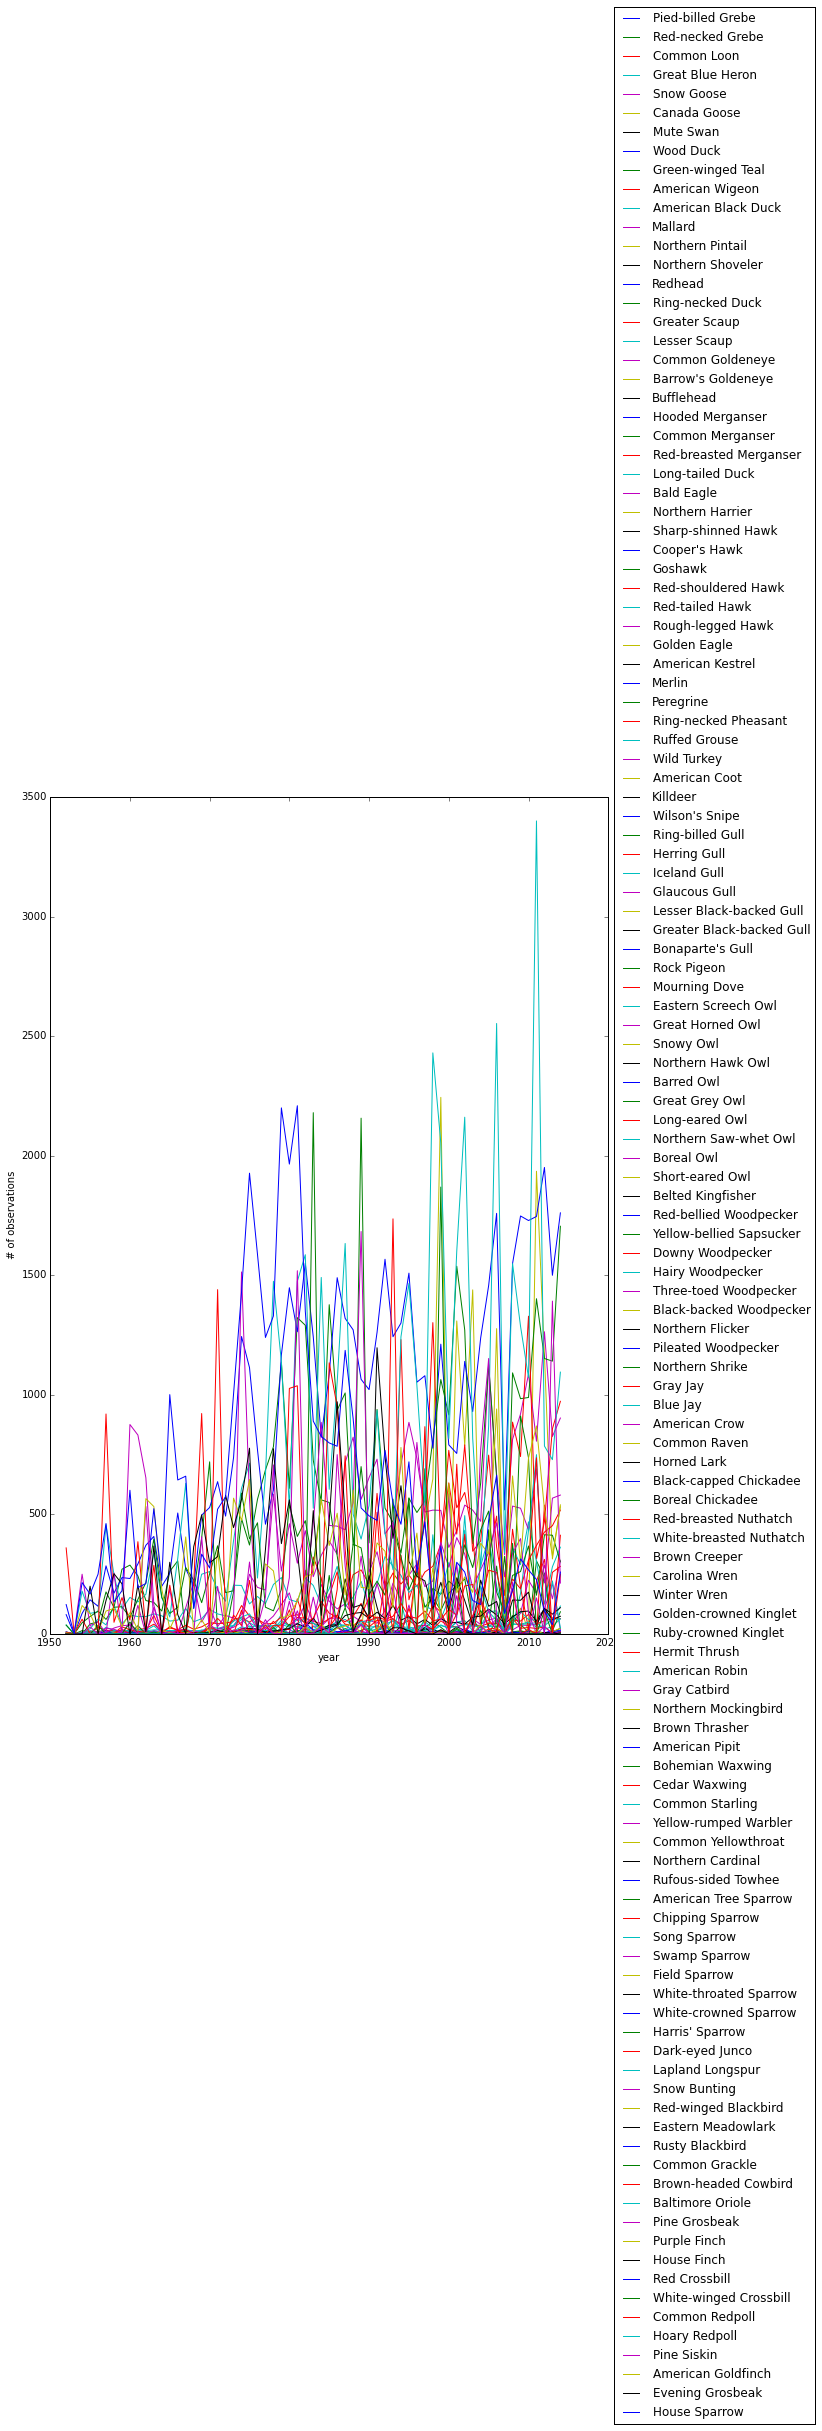

In [13]:
f, ax = plt.subplots(1, 1, figsize=(10, 15))
for spc in all_spc_names[:]:
    x, y = get_timeseries(spc, df)
    ax.plot(x, y, label=spc)
ax.set_xlabel("year")
ax.set_ylabel("# of observations")
# ax.set_yscale('symlog')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Potential visualization ideas:
* Voronoi line graph: http://bl.ocks.org/mbostock/8033015
* Table with circles to indicate count: http://asifr.com/punchcard-visualization-using-d3js.html

In [15]:
def get_n_unique_spc(yr, df): 
    df_temp = df.query("type != 'participants'")
    return len([n for n in list(df_temp[str(yr)]) if n > 0.1])

In [16]:
y_unique_spc = [get_n_unique_spc(yr, df) for yr in years]

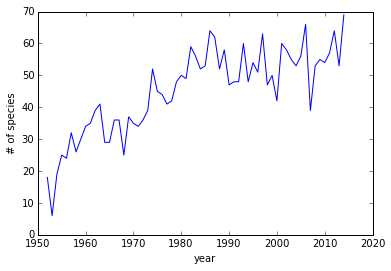

In [17]:
plt.plot(years, y_unique_spc)
plt.xlabel('year')
plt.ylabel('# of species')

<Container object of 63 artists>

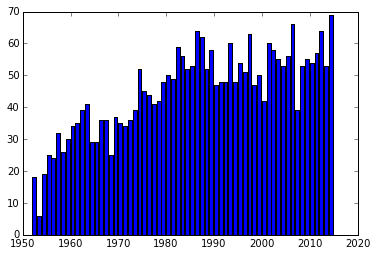

In [18]:
plt.bar(years, y_unique_spc)

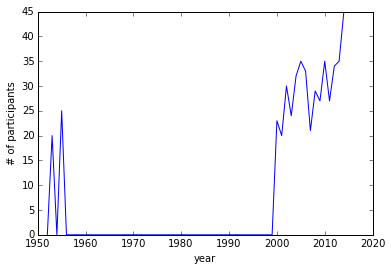

In [19]:
x2, y2 = get_timeseries('No. of Participants', df)
plt.plot(x2, y2)
plt.ylabel('# of participants')
plt.xlabel('year')

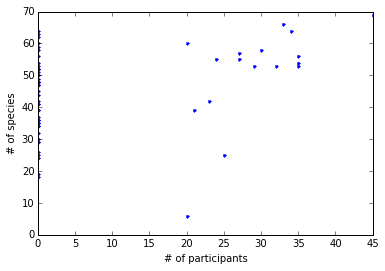

In [20]:
plt.plot(y2, y_unique_spc, '.')
plt.xlabel('# of participants')
plt.ylabel('# of species')

### Create JSON data file for use with the punchcard viz

In order to work with the code at: http://asifr.com/punchcard-visualization-using-d3js.html

it should have the following format:

In [21]:
json_sample = [{"articles": [[2010, 6], [2011, 10], [2012, 11], [2013, 23], [2006, 1]], 
                "total": 51, "name": "The Journal of neuroscience"}, 
               {"articles": [[2008, 1], [2010, 3], [2011, 4], [2012, 17], [2013, 10]], 
                "total": 35, "name": "Nature neuroscience"}]

Create totals column

In [22]:
for n, yr in enumerate(years):
    if n == 0: total_series = df[str(yr)]
    else: total_series += df[str(yr)]

In [23]:
df['total'] = total_series

Create max count column

In [24]:
import numpy as np

In [35]:
df_cp['total'] = df['total']
df_cp['max_count'] = df[[str(yr) for yr in years]].max(axis=1)
df_cp['median_count'] = df[[str(yr) for yr in years]].median(axis=1)
df_cp['max_sort'] = np.argsort(df_cp.max_count)

In [36]:
def _int(val):
    return 'CP' if val=='CP' else int(val)

def create_web_data(df):
    web_data = []
    for i in df.index:
        if df.type[i] in ('species', 'special'):
            row_dict = {}
            row_dict['name'] = df.name[i]
            row_dict['max_count'] = _int(df.max_count[i])
            row_dict['median_count'] = _int(df.median_count[i])
            row_dict['max_sort'] = int(df.max_sort[i])
            x, y = get_timeseries(df.name[i], df)
            row_dict['observations'] = [[x[j], y[j]] for j,_ in enumerate(x) if y[j]>0]
            web_data.append(row_dict)
    return web_data

In [37]:
import json

Create a json file without replacing the CPs 

In [38]:
web_data_cp = create_web_data(df_cp)
json_str = json.dumps(web_data_cp)
f = open("../data/web_data_cp.json", 'w')
f.write(json_str)
f.close()

Generate the json for the species count / total count bar chart

In [61]:
_y_unique_spc = [get_n_unique_spc(yr, df) for yr in years]

In [62]:
def get_tot_count(yr, df): 
    df_temp = df.query("type != 'participants'")
    return int(sum(list(df_temp[str(yr)])))

tot_count = [get_tot_count(yr, df) for yr in years]

In [63]:
bar_data = [{"yr": years[i], 'n_spc': _y_unique_spc[i], 'tot_count':tot_count[i]} for i,_ in enumerate(years)]

In [64]:
json_str = json.dumps(bar_data)
f = open("../data/bar_data.json", 'w')
f.write(json_str)
f.close()

In [65]:
len(df.query("type != 'participants'"))

142

In [66]:
len(df)

143